In [ ]:
'''

This notebook takes as input a pdf file and finds the subject and object from the pair of sentences and then creates a
knowledge graph out of it.

'''

In [18]:
import os
import pandas as pd
import re
import numpy as np
import spacy
from nltk.tokenize import TreebankWordTokenizer,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet,stopwords
from nltk import pos_tag
import networkx as nx
import warnings
import spacy
from tqdm import tqdm
import string

import PyPDF2
from io import StringIO
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [19]:
def read_data(path,threshold,delta=0):
    output_string = StringIO()
    with open(path, 'rb') as in_file:
        parser = PDFParser(in_file)
        doc = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        for page in PDFPage.create_pages(doc):
            interpreter.process_page(page)

    sentences = sent_tokenize(output_string.getvalue())
    return sentences[delta:delta+threshold]


In [20]:
def do_preprocessing(corpus):
    
    clean_sentences = []
    stopwords_list = stopwords.words('english')
    for sentence in corpus:
        text = re.sub(r"[^a-zA-Z']"," ",sentence) 
        text = ' '.join([word for word in text.split(' ') if word.lower() not in stopwords_list])
        text = re.sub(r"(\s)(\s)+"," ",text)
        text = text.strip()
        clean_sentences.append(text)
    
    return clean_sentences
        

In [21]:
def get_entities(sent):
    
    nlp = spacy.load('en_core_web_sm')
    
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""
    
    subject = objectt = False
    sub_i = obj_i = -1
    #############################################################
  
    for i,tok in enumerate(nlp(sent)):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
                subject = True
                sub_i = i

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
                objectt = True
                obj_i = i
            
            if subject and objectt:
                break
                
            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
            
    
    if subject and objectt:
        return [ent1.strip().capitalize(), ent2.strip().capitalize()],sub_i,obj_i
    
    else:
        return -1,sub_i,obj_i

In [22]:
def find_relation(sentence,result,tokenizer,lemmatizer,sub_i,obj_i):
        nltk_tagged = pos_tag(tokenizer.tokenize(sentence))
        for i,(word,tag) in enumerate(nltk_tagged):
            if tag.startswith('V') and (i > sub_i and i < obj_i):
                return word.lower()
            
        return None

In [23]:
def find_nodes_and_edges(corpus):
    entity_pairs = []
    relations = []

    tokenizer = TreebankWordTokenizer()
    lemmatizer =  WordNetLemmatizer()
    
    for sentence in tqdm(corpus):
        result,sub_i,obj_i = get_entities(sentence)
        if result != -1:
            verb = find_relation(sentence,result,tokenizer,lemmatizer,sub_i,obj_i)
            if verb != None:
                entity_pairs.append(result)
                relations.append(lemmatizer.lemmatize(verb))
        
    
    return entity_pairs,relations

In [24]:
def make_knowledge_graph(corpus_path,threshold,delta=0):
    print('Starting data reading')
    corpus = read_data(corpus_path,threshold,delta)
    print(f'Data reading completed.Number of sentences are {len(corpus)}')
    
    print('Preprocessing started')
    corpus = do_preprocessing(corpus)
    print('Preprocessing completed')
    
    
    print('Getting nodes and edges')
    x,y = find_nodes_and_edges(corpus)
    print(f'Nodes and edges successfully created. Total number of relations found are {len(x)}')
    
    source = [x[0] for x in x]
    target = [x[1] for x in x]
    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':y})
    return kg_df
    

def plot_graph(kg_df,src=False,dst=False,edg=False):
    
    query = ""
    if src :
        query += "(kg_df['source'] == src)"
    
    if dst:
        query += ("& " if src else "") + "(kg_df['target'] == dst)"
    
    if edg:
        query += (("& " if dst else "") or ("& " if src else "")) + "(kg_df['edge'] == edg)"
    
    if query == "":
        G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
    
    else:
        G=nx.from_pandas_edgelist(kg_df[eval(query,{"src":src,"dst":dst,"edg":edg,"kg_df":kg_df})], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph()) 
        
    plt.figure(figsize=(12,10))
    pos = nx.spring_layout(G,k=0.5)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos,node_size=1500)
    
    edge_labels = nx.get_edge_attributes(G,'edge')
    formatted_edge_labels = {(elem[0],elem[1]):edge_labels[elem] for elem in edge_labels}
    nx.draw_networkx_edge_labels(G,pos,edge_labels=formatted_edge_labels,font_color='green')
    
    plt.show()
    

In [25]:
kg_df = make_knowledge_graph("../Data Files/harry_potter_gof.pdf",200,0)

Starting data reading
Data reading completed.Number of sentences are 200
Preprocessing started
Preprocessing completed
Getting nodes and edges


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:16<00:00,  2.60it/s]

Nodes and edges successfully created. Total number of relations found are 72


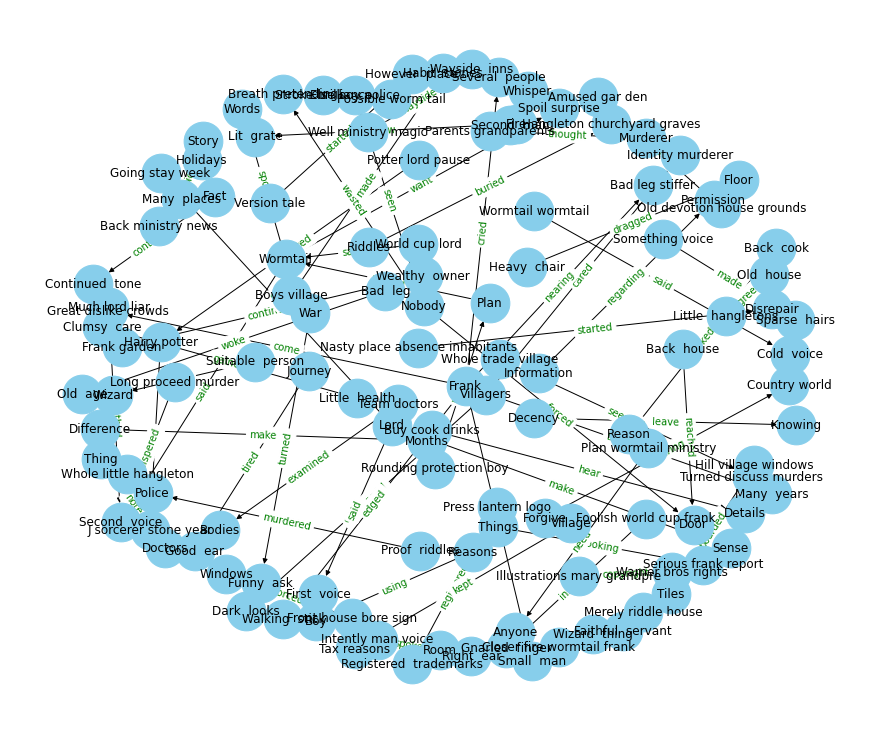

In [26]:
plot_graph(kg_df)

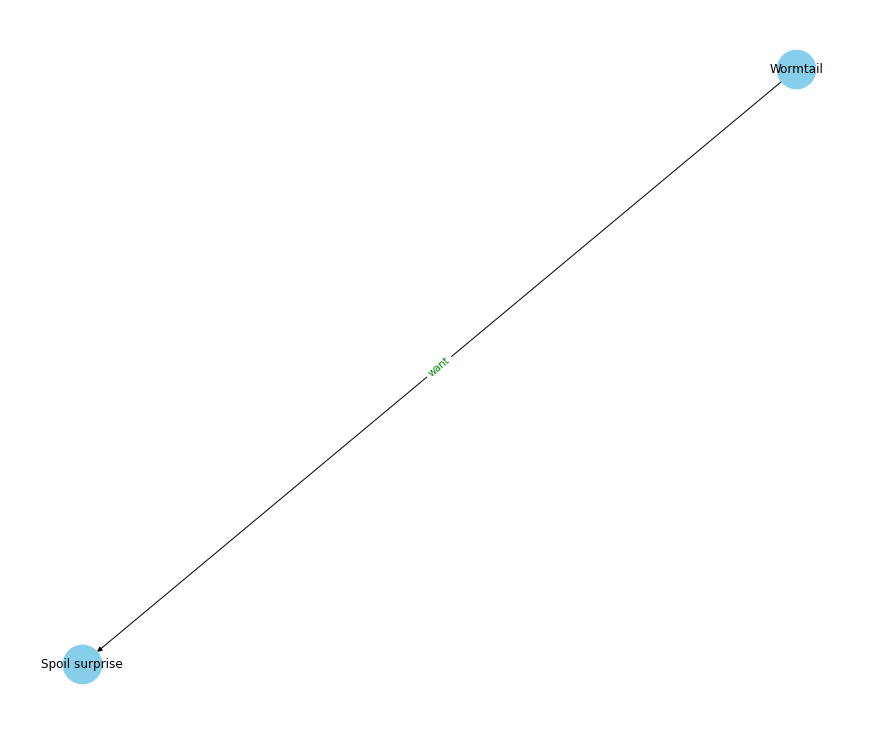

In [27]:
plot_graph(kg_df,"Wormtail","Spoil surprise","want")

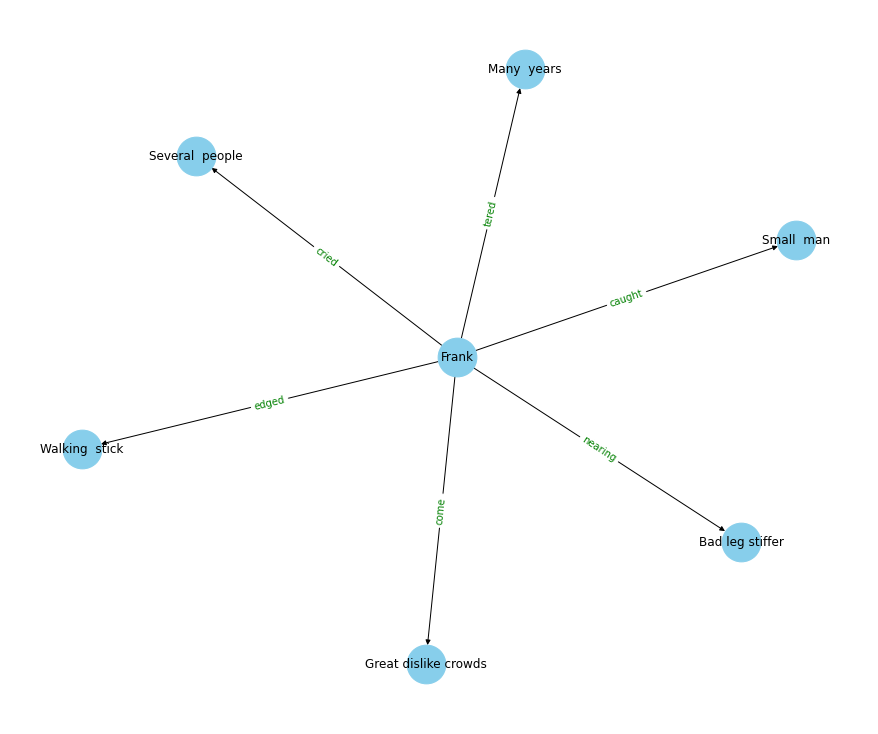

In [28]:
plot_graph(kg_df,"Frank")

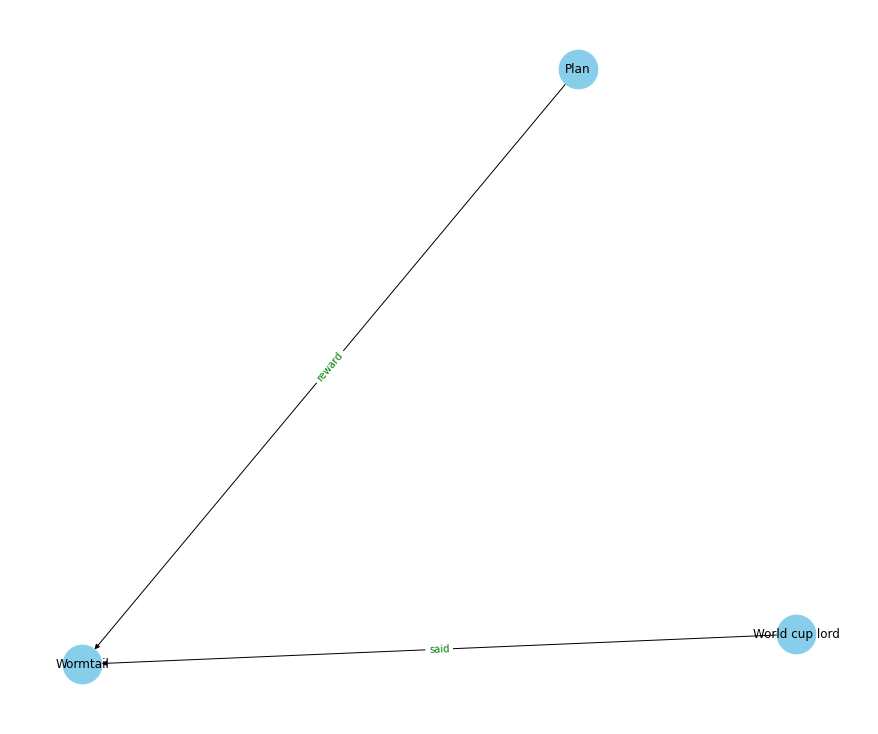

In [29]:
plot_graph(kg_df,dst="Wormtail")

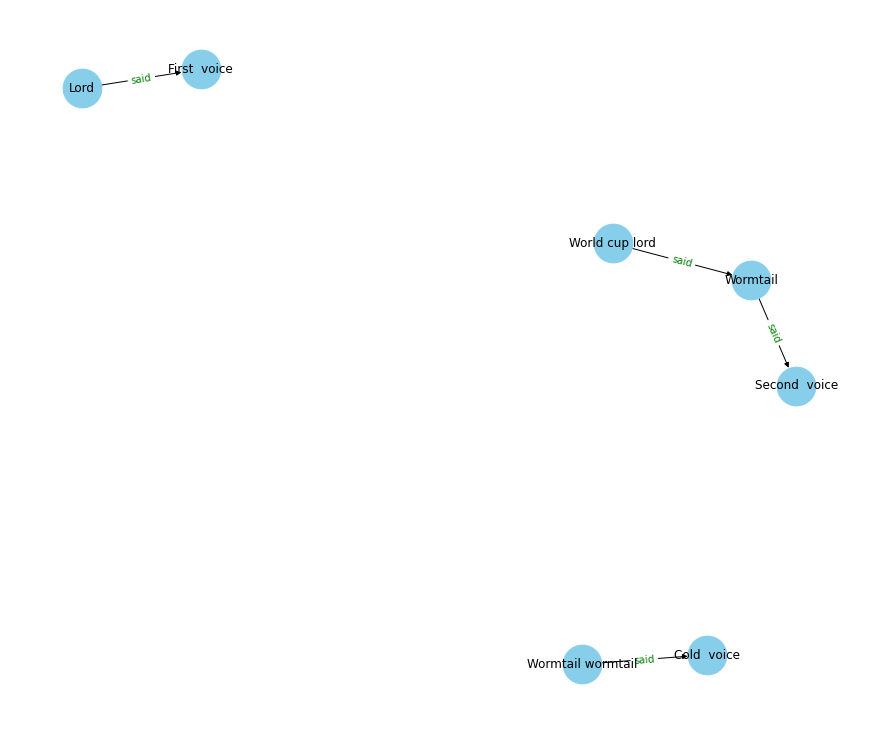

In [30]:
plot_graph(kg_df,edg="said")

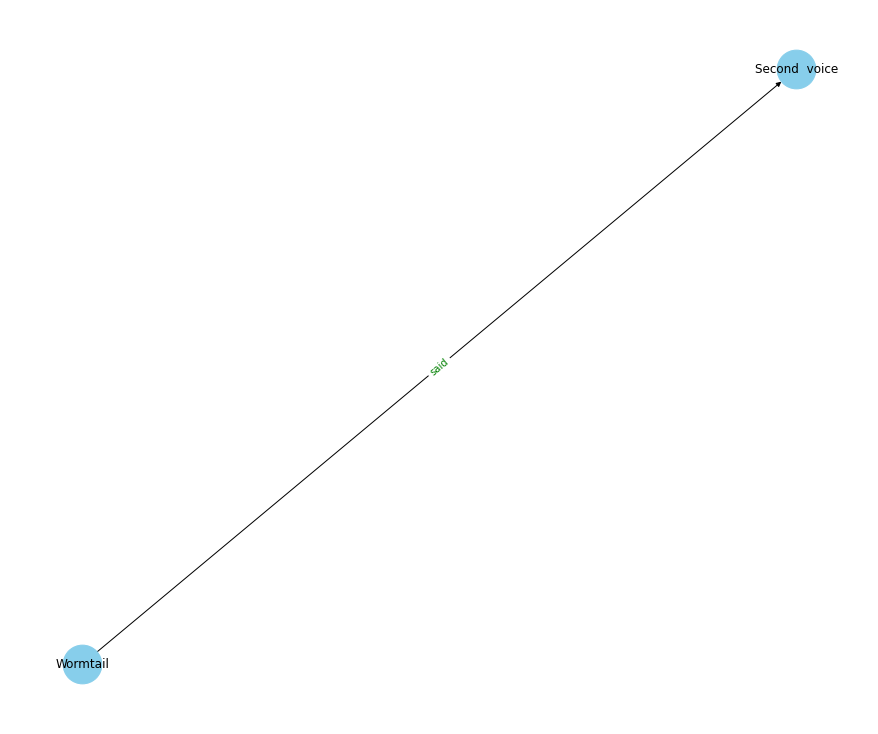

In [31]:
plot_graph(kg_df,src="Wormtail",edg="said")

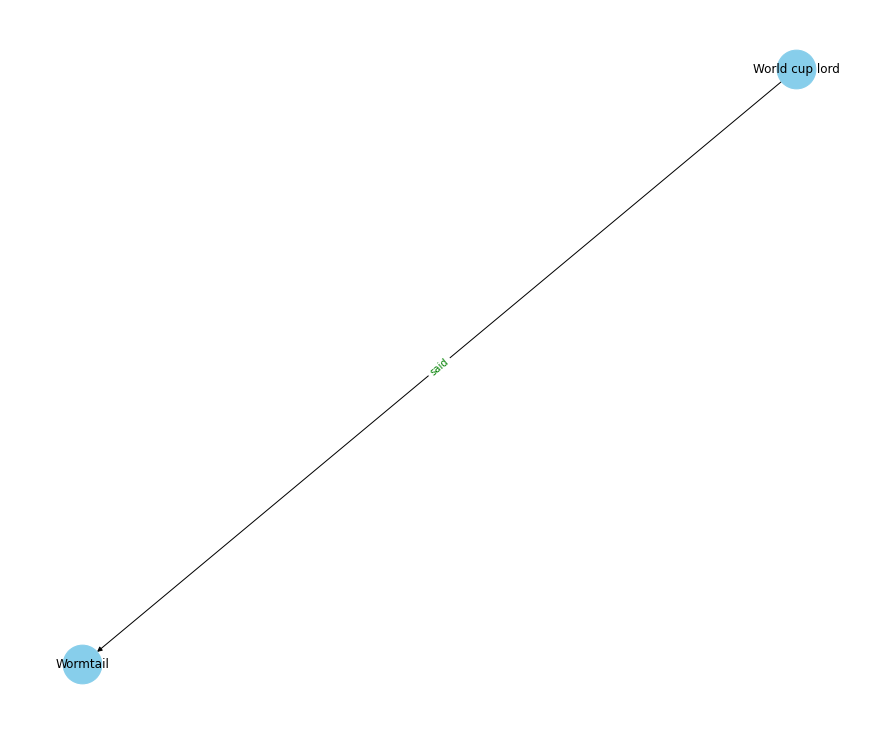

In [32]:
plot_graph(kg_df,dst="Wormtail",edg="said")